In [14]:
# imports and settings
from pandas import DataFrame
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision.datasets import MNIST
from torchvision.transforms import ToPILImage

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# plot settings
sns.set_style('white')
plt.rcParams['figure.dpi'] = 100

# Build a NN to classify 3's and 7's in the MNIST Dataset

The MNIST dataset is large collection of hanwritten digits, 0--9, represented as 28x28 grayscale images with values ranging from 0 (black) to 255 (white).

We're going to:

0.  Download and prepare the data.  Since we only want to use 3's and 7's for our first attempt we'll need to filter out the unnecessary digits.

1.  Create our NN model.

2.  Build the PyTorch Dataset and Dataloader.

3.  Train the model.

4.  Visualize the results.

## Step 0 - Download and Prepare the Data

This will take just a few seconds the first time you run this cell in a session:

In [15]:
mnist_train = MNIST(root='./data', train = True, download = True, transform = None)
mnist_valid = MNIST(root='./data', train = False, download = True, transform = None)

If we look at `mnist_train` we'll see a summary of the dataset:

In [16]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

This is already a PyTorch Dataset but since we're only interested in 3's and 7's we'll extract the data and filter out the unnecessary digits and build our own Datset.

The grayscale image data is stored in the `.data` attribute while the targets are stored in the `.targets` attribute.

Let's look at a few of the targets first:

In [21]:
mnist_train.targets[21:40]

tensor([0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6])

The values for each target correspond exactly to the digit in the image.  Let's look at the eigth image which should be a three:

In [22]:
image3 = mnist_train.data[27]
image3.shape

torch.Size([28, 28])

Let's have a peek at the raw data in this tensor:

In [23]:
image3

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   9,  80, 207, 255,
         254, 254, 254,  97,  80,  80,  44,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,  39, 15

Here is a nice visualization using a Pandas DataFrame.  This requires matplotlib as well.

In [27]:
df = DataFrame(image3[4:22,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('gray')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,9,80,207,255,254,254,254,97,80,80,44,0
2,0,0,39,158,158,158,168,253,253,253,253,253,253,253,253,253,210,38
3,0,0,226,253,253,253,253,253,253,253,253,253,253,253,253,253,253,241
4,0,0,139,253,253,253,238,113,215,253,253,253,253,253,253,253,253,253
5,0,0,39,34,34,34,30,0,31,148,34,204,235,253,253,253,253,253
6,0,0,91,0,0,0,0,0,0,0,0,35,199,253,253,253,253,244
7,0,0,0,0,0,0,0,11,33,202,202,216,253,253,253,253,241,89
8,0,0,0,0,0,0,11,167,253,253,253,253,253,253,253,238,82,0
9,0,0,0,0,0,0,27,253,253,253,253,253,253,253,253,96,0,0


`matplotlib.pyplot` can be used for a similar visualization (we'll be using `imshow` frequently)

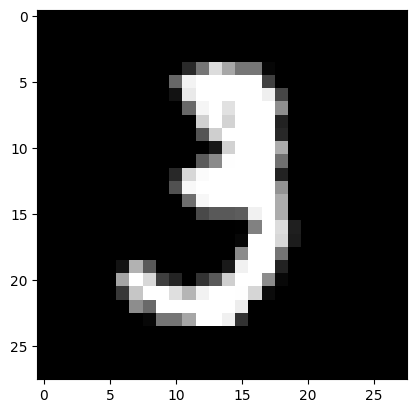

In [7]:
plt.imshow(image3,cmap = 'gray');

It doesn't look so great when it's scaled large like this, but if we convert it to a PIL image and display it, then it looks like a 3:

In [8]:
transform_pil = ToPILImage() # instantiate transform
image3_pil = transform_pil(image3)
image3_pil

### Preparing the Data

We'll start with the training data.  

1. Extract the tensors containing the inputs and targets from the downloaded PyTorch Dataset and get their shapes so we know what we're dealing with. We'll initially work with just the training set.

2.  Create a tensor of booleans that is True if the target is a 3 or a 7 and False otherwise.  We're going to use this tensor as an index set to extract the inputs and targets we want.  A boolean index set is often called a **mask**.

3.  Use the mask to filter the inputs and targets.

4. Make the targets into 0's and 1's (as floats).  Use a 1 for the threes:

5.  Flatten the 2D inputs (the images) into 1D tensors:

6.  Normalize the input values to be between 0 and 1:

7.  Put these steps into a function to make it easy to apply both the training and validation sets.  Your function should have inputs and targets as arguments and return the prepared inputs and targets.

In [13]:
def filter_convert_37( inputs, targets):

    return inputs, targets

8.  Apply your function to `mnist_train.data` and `mnist_train.targets` to get `X_train` and `y_train`.  Do the same with `mnist_valid`.  Finally print out the shapes of the prepared inputs and targets to check that everything seem reasonable.

**Exercise**. Figure out how many 3's and 7's there are in each of the datasets.

Now the data is set up similarly to how we had it in the Logistic Regression notebook.  Instead of having points in two dimensions each digit is represented by a point in 784 dimensions.  The samples are also larger:  12396 digits in the training set and 2038 digits in the validation set.

**Exercise**. Figure out how many 3's and 7's there are in each of the datasets.

Now the data is set up similarly to how we had it in the Logistic Regression notebook.  Instead of having points in two dimensions each digit is represented by a point in 784 dimensions.  The samples are also larger:  12396 digits in the training set and 2038 digits in the validation set.

## Step 1 - Build a Simple NN in Pytorch

Use the NN in the Logistic Regression Notebook (most recent version) as a starting point and build NN with the following specifications:

* Input Layer: 784 inputs
* Hidden Layer: 30 neurons + ReLU activation
* Output Layer: map the 30 outputs of the hidden layer to a single output and apply a sigmoid activation

## Step 2 - Datasets and Dataloaders

Follow along with the Logistic Regression notebook (most recent version) to build training and validation Datasets and Dataloaders.

## Step 3 - Train the model

Use the training loop from the Logistic Regression notebook to train our 3's and 7's MNIST predictor model.  You'll likely need to experiment with the total number of epochs, the learning rate, and the batch size.  

What kind of accuracy can you get on the validation set?

## Step 4 - Visualize the results

Plot the training and validation loss versus epochs.

Go back to the training loop and add the ability to record the training and validation accuracy at each step, then plot those too.